## Module 1 :  Data Augmentation for ISEAR Dataset

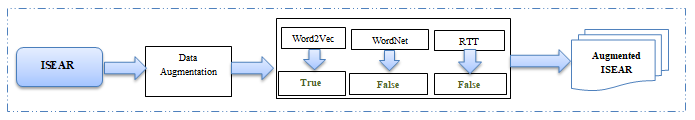

In [1]:
from PIL import Image
Image.open("arc_1.png")

In [ ]:
#https://stackoverflow.com/questions/17037668/how-to-disable-cookie-handling-with-the-python-requests-library
from http import cookiejar  # Python 2: import cookielib as cookiejar
class BlockAll(cookiejar.CookiePolicy):
    return_ok = set_ok = domain_return_ok = path_return_ok = lambda self, *args, **kwargs: False
    netscape = True
    rfc2965 = hide_cookie2 = False

In [ ]:
!pip install textaugment gensim

In [ ]:
!pip install roundtrip

  Using cached https://files.pythonhosted.org/packages/b9/bf/bdd34a6c8b308aa8d1a2ead03fa14cd1bdc4fd9b6c649b12bd47f3ebcab9/google_cloud_translate-3.0.2-py2.py3-none-any.whl


In [1]:
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
import re
import nltk
import random

In [ ]:
import textaugment, gensim
from textaugment import Word2vec
from textaugment import Wordnet
#from textaugment import Translate
from roundtrip import backtranslate
from sklearn.utils import shuffle

In [ ]:
import nltk
nltk.download(['wordnet','punkt','averaged_perceptron_tagger'])

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [ ]:
# Load Google Word2vec embeddings
!wget "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

--2020-12-17 14:01:37--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.17.163
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.17.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz.1’

GoogleNews-vectors- 100%[===================>]   1.53G  37.5MB/s    in 36s     

2020-12-17 14:02:13 (43.4 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz.1’ saved [1647046227/1647046227]



In [ ]:
import requests

# 1. Data Augmentation class 

In [ ]:
class Data_Augmentation :
  def __init__(self,per,Word2vec=True, Wordnet = False ,Round_Trip_Translation = False):
    #self.data = data
    self.per = per
    self.Word2vec = Word2vec                                  #first augmented method
    self.Wordnet = Wordnet                                    # second augmented method
    self.Round_Trip_Translation = Round_Trip_Translation      # third augmented method
    #self.Word2vec_function1 = Word2vec_function1

  def Word2vec_function1(self ,dataset ,input_idx , target_idx, len_of_aug_data )  :
    model = gensim.models.KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300.bin.gz', binary=True)
    #print(model)
    t = Word2vec(model=model)
    for r in range(0,len_of_aug_data):                             # how much data you want to increse is a len_of_aug_data
      dataset=shuffle(dataset)                                     # shuffling the dataset to always get random index value
      sentence = t.augment(dataset.iloc[:,input_idx][r])           # augmenting sentence with particular index
      label = dataset.iloc[:,target_idx][r]                        # extracting lable from that index
      #print(sentence)
      new_data = pd.DataFrame([[sentence, label] ],columns=[dataset.columns[input_idx],dataset.columns[target_idx]])
      #print(new_data)        # creating single df of output with sentence and label
      dataset = dataset.append(new_data, ignore_index=True)        # appending the data to base dataset i.e. ISEAR dataset
    #print(dataset.shape)
    return dataset

  def Wordnet_function(self , dataset ,input_idx , target_idx ,len_of_aug_data):
    t = Wordnet()
    for r in range(0,len_of_aug_data):
      dataset=shuffle(dataset)
      sentence = t.augment(dataset.iloc[:,input_idx][r])
      label = dataset.iloc[:,target_idx][r]
      #print(sentence)
      new_data = pd.DataFrame([[sentence, label] ],columns=[dataset.columns[input_idx],dataset.columns[target_idx]])
      #print(new_data)
      dataset = dataset.append(new_data, ignore_index=True)
    #print(dataset.shape)
    return dataset

  #https://github.com/samhavens/roundtrip
  def RTT_function(self , dataset ,input_idx , target_idx ,len_of_aug_data) :
    for r in range(0,len_of_aug_data):
      dataset=shuffle(dataset)
      sentence = backtranslate(dataset.iloc[:,input_idx][r], "de")
      label = dataset.iloc[:,target_idx][r]
      #print(sentence)
      new_data = pd.DataFrame([[sentence, label]],columns=[dataset.columns[input_idx],dataset.columns[target_idx]])
      #print(new_data)
      dataset = dataset.append(new_data, ignore_index=True)
    #print(dataset.shape)
    return dataset

  # from whole dataset which column need to be augmented ? 
  def augmentation(self,data,input_idx , target_idx):           
    if type(data) == pd.core.series.Series:                     # if the givne datatype is series or list or numpy array
      data = pd.DataFrame(data)                                 # it will get converted into standard Dataframe format
    elif type(data) == list or type(data) == np.ndarray:        # for further calculations
      data = pd.DataFrame(data = data)
    else:
      pass
 
    len_of_data = data.shape[0]                                 # the counter will increase a/c to selected method 
    counter = 0                                                 # so the data will get partion a/c to that
    if self.Word2vec == True:                                   # if one method selected 1 partion 
      counter += 1                                              # if two method selected 2 partitions
    if self.Wordnet == True:
      counter +=1
    if self.Round_Trip_Translation == True:
      counter +=1
 
    partition = self.per/counter                                # dataset will be partitioned 
    #print(partition)
    len_word2vec = 0 
    len_wordnet = 0
    len_rtt = 0

    s = requests.Session()
    s.cookies.set_policy(BlockAll())
    
    # if all three methods are selected , 3 partions of the data
    if self.Word2vec == True and self.Wordnet == True and self.Round_Trip_Translation == True :
      len_word2vec = int((partition /100)*len_of_data)
      len_wordnet = int(( partition /100 )*len_of_data)
      len_rtt = int((( self.per-partition*2) / 100)*len_of_data) 
    # two methods are selected : wordnet and RTT .
    elif self.Word2vec == False and self.Wordnet == True and self.Round_Trip_Translation == True :
      len_wordnet = int((partition / 100)*len_of_data)
      len_rtt = int(((self.per-partition)/100)*len_of_data )
    # two methods selected : word2vec and RTT
    elif self.Word2vec == True and self.Wordnet == False and self.Round_Trip_Translation == True :
      len_word2vec = int(( partition / 100)*len_of_data)
      len_rtt = int(((self.per-partition) /100)*len_of_data)
    # two methods selected : word2vec and wordnet
    elif self.Word2vec == True and self.Wordnet == True and self.Round_Trip_Translation == False :
      len_word2vec = int(( partition / 100)*len_of_data)
      len_wordnet = int(((self.per-partition)/100)*len_of_data )
    #only one method selected : word2vec
    elif self.Word2vec == True and self.Wordnet == False and self.Round_Trip_Translation == False :
      len_word2vec = int(( partition / 100)*len_of_data)
    # only one method selected : Wrdnet
    elif self.Word2vec == False and self.Wordnet == True and self.Round_Trip_Translation == False :
      len_wordnet = int(( partition / 100)*len_of_data)
    # only one augmented method : Word2vec
    elif self.Word2vec == False and self.Wordnet == False and self.Round_Trip_Translation == True :
      len_rtt = int(( partition / 100)*len_of_data)
    else:
      print("Select atlesat one augmentation method")
      

    if self.Word2vec == True:
      data = shuffle(data)
      data = self.Word2vec_function1(data ,input_idx , target_idx, len_word2vec )

    if self.Wordnet == True:
      data = shuffle(data)
      data = self.Wordnet_function(data ,input_idx , target_idx , len_wordnet)

    if self.Round_Trip_Translation == True:
      data = shuffle(data)
      data = self.RTT_function(data ,input_idx , target_idx , len_rtt)
    #print(data.shape)
    return data  

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## 2. Loading the Data 

In [5]:
# bad lines wih too much commas will be dropped
isear_data = pd.read_csv("/content/gdrive/MyDrive/CS1/Data/isear.csv",delimiter = "|",error_bad_lines=False , warn_bad_lines=False) 

In [ ]:
isear_data.head(2)

,ID,CITY,COUN,SUBJ,SEX,AGE,RELI,PRAC,FOCC,MOCC,FIEL,EMOT,WHEN,LONG,INTS,ERGO,TROPHO,TEMPER,EXPRES,MOVE,EXP1,EXP2,EXP10,PARAL,CON,EXPC,PLEA,PLAN,FAIR,CAUS,COPING,MORL,SELF,RELA,VERBAL,NEUTRO,Field1,Field3,Field2,MYKEY,SIT,STATE,Unnamed: 42
0,11001,1,1,1,1,33,1,2,6,1,2,1,4,4,3,0,0,1,1,0,1,0,0,0,1,2,1,1,1,4,4,2,3,3,2,0,joy,4,3,110011,"During the period of falling in love, each tim...",1,NaN
1,11001,1,1,1,1,33,1,2,6,1,2,2,4,3,2,2,0,0,1,0,0,0,0,2,1,1,3,0,2,2,1,3,2,2,0,0,fear,3,2,110012,When I was involved in a traffic accident.,1,NaN


In [6]:
isear_data.shape

(7503, 43)

In [ ]:
isear_data.columns.get_loc("SIT") , isear_data.columns.get_loc("Field1")

(40, 36)

In [ ]:
# 15 percentage selected and all three methods selected
da = Data_Augmentation(per= 15, Word2vec=True, Wordnet = True , Round_Trip_Translation = True)

In [ ]:
augmented_data = da.augmentation(data=isear_data , input_idx = 40 , target_idx = 36)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [ ]:
augmented_data.head(2)

,ID,CITY,COUN,SUBJ,SEX,AGE,RELI,PRAC,FOCC,MOCC,FIEL,EMOT,WHEN,LONG,INTS,ERGO,TROPHO,TEMPER,EXPRES,MOVE,EXP1,EXP2,EXP10,PARAL,CON,EXPC,PLEA,PLAN,FAIR,CAUS,COPING,MORL,SELF,RELA,VERBAL,NEUTRO,Field1,Field3,Field2,MYKEY,SIT,STATE,Unnamed: 42
0,261004.0,1.0,26.0,4.0,2.0,27.0,4.0,1.0,7.0,1.0,1.0,5.0,4.0,4.0,3.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,2.0,1.0,3.0,0.0,3.0,2.0,4.0,3.0,3.0,1.0,0.0,2.0,disgust,4.0,3.0,2610045.0,When my husband quarrelled with me for no reas...,1.0,NaN
1,331027.0,1.0,33.0,27.0,1.0,21.0,8.0,2.0,7.0,4.0,8.0,5.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,3.0,2.0,0.0,2.0,4.0,0.0,2.0,2.0,1.0,0.0,disgust,1.0,1.0,3310275.0,"During a recent meeting, Mr. A showed his exci...",1.0,NaN


In [ ]:
augmented_data.shape

(8628, 43)

In [ ]:
type(augmented_data)

pandas.core.frame.DataFrame

In [ ]:
# saving the dataframe 
augmented_data.to_csv('/content/gdrive/MyDrive/CS1/Data/augmented_data_15.csv',index= False) 

## 3. Loading 15% augmented ISEAR data 

In [ ]:
# bad lines wih too much commas will be dropped
augmented_data_15 = pd.read_csv("/content/gdrive/MyDrive/CS1/Data/augmented_data_15.csv",error_bad_lines=False , warn_bad_lines=False)

In [ ]:
augmented_data_15.shape

(7878, 45)

In [ ]:
augmented_data_15.head(2)

,Unnamed: 0,Unnamed: 0.1,ID,CITY,COUN,SUBJ,SEX,AGE,RELI,PRAC,FOCC,MOCC,FIEL,EMOT,WHEN,LONG,INTS,ERGO,TROPHO,TEMPER,EXPRES,MOVE,EXP1,EXP2,EXP10,PARAL,CON,EXPC,PLEA,PLAN,FAIR,CAUS,COPING,MORL,SELF,RELA,VERBAL,NEUTRO,Field1,Field3,Field2,MYKEY,SIT,STATE,Unnamed: 42
0,0,0,11083.0,1.0,1.0,83.0,1.0,27.0,8.0,2.0,7.0,4.0,1.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,shame,0.0,0.0,110836.0,[ I do not remember when I last felf ashamed. ...,1.0,NaN
1,1,1,171061.0,1.0,17.0,61.0,2.0,20.0,2.0,2.0,6.0,6.0,1.0,2.0,2.0,2.0,4.0,4.0,1.0,2.0,3.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,fear,2.0,4.0,1710612.0,I was testing my new roller skates in the stre...,1.0,NaN


In [ ]:
augmented_data_15 = augmented_data_15.drop(['Unnamed: 0','Unnamed: 0.1'],axis=1)

In [ ]:
augmented_data_15.shape

(7878, 43)

In [ ]:
augmented_data_15.head(2)

,ID,CITY,COUN,SUBJ,SEX,AGE,RELI,PRAC,FOCC,MOCC,FIEL,EMOT,WHEN,LONG,INTS,ERGO,TROPHO,TEMPER,EXPRES,MOVE,EXP1,EXP2,EXP10,PARAL,CON,EXPC,PLEA,PLAN,FAIR,CAUS,COPING,MORL,SELF,RELA,VERBAL,NEUTRO,Field1,Field3,Field2,MYKEY,SIT,STATE,Unnamed: 42
0,11083.0,1.0,1.0,83.0,1.0,27.0,8.0,2.0,7.0,4.0,1.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,shame,0.0,0.0,110836.0,[ I do not remember when I last felf ashamed. ...,1.0,NaN
1,171061.0,1.0,17.0,61.0,2.0,20.0,2.0,2.0,6.0,6.0,1.0,2.0,2.0,2.0,4.0,4.0,1.0,2.0,3.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,fear,2.0,4.0,1710612.0,I was testing my new roller skates in the stre...,1.0,NaN


In [ ]:
da = Data_Augmentation(per=15, Word2vec=True, Wordnet = True , Round_Trip_Translation = False)

In [ ]:
augmented_data = da.augmentation(augmented_data_15 , input_idx = 40 , target_idx = 36)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [ ]:
augmented_data.shape

(9058, 43)

In [ ]:
# saving the dataframe 
augmented_data.to_csv('/content/gdrive/MyDrive/CS1/Data/augmented_data_30.csv',index= False) 

## 4. Loading 30% augmented ISEAR data 

In [ ]:
# bad lines wih too much commas will be dropped
augmented_data_30 = pd.read_csv("/content/gdrive/MyDrive/CS1/Data/augmented_data_30.csv",error_bad_lines=False , warn_bad_lines=False)

In [ ]:
augmented_data_30.shape

(9058, 43)

In [ ]:
augmented_data_30.head(2)

,ID,CITY,COUN,SUBJ,SEX,AGE,RELI,PRAC,FOCC,MOCC,FIEL,EMOT,WHEN,LONG,INTS,ERGO,TROPHO,TEMPER,EXPRES,MOVE,EXP1,EXP2,EXP10,PARAL,CON,EXPC,PLEA,PLAN,FAIR,CAUS,COPING,MORL,SELF,RELA,VERBAL,NEUTRO,Field1,Field3,Field2,MYKEY,SIT,STATE,Unnamed: 42
0,121041.0,1.0,12.0,41.0,2.0,20.0,8.0,2.0,7.0,7.0,1.0,2.0,3.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,2.0,2.0,1.0,1.0,2.0,1.0,2.0,2.0,0.0,0.0,fear,1.0,1.0,1210412.0,When I come home late at night.,1.0,NaN
1,41041.0,1.0,4.0,41.0,2.0,22.0,1.0,1.0,6.0,6.0,2.0,7.0,1.0,2.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,3.0,2.0,2.0,0.0,5.0,0.0,3.0,0.0,3.0,0.0,guilt,2.0,1.0,410417.0,When I noticed that my little sister was sulki...,1.0,NaN


In [ ]:
da = Data_Augmentation(per=15, Word2vec=True, Wordnet = False , Round_Trip_Translation = True)

In [ ]:
aug_data = da.augmentation(augmented_data_30 , input_idx = 40 , target_idx = 36)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [ ]:
#saving the dataframe 
aug_data.to_csv('/content/gdrive/MyDrive/CS1/Data/augmented_data_45.csv',index= False) 

## 5. Loading 45% augmented ISEAR data 

In [ ]:
# bad lines wih too much commas will be dropped
augmented_data_45 = pd.read_csv("/content/gdrive/MyDrive/CS1/Data/augmented_data_45.csv",error_bad_lines=False , warn_bad_lines=False)

In [ ]:
augmented_data_45.shape

(10416, 43)

In [ ]:
da = Data_Augmentation(per=15, Word2vec=False, Wordnet = True, Round_Trip_Translation = True)

In [ ]:
aug_data = da.augmentation(augmented_data_45 , input_idx = 40 , target_idx = 36)

In [ ]:
#saving the dataframe 
aug_data.to_csv('/content/gdrive/MyDrive/CS1/Data/augmented_data_60.csv',index= False) 

## 6. Loading 60% augmented ISEAR data 

In [ ]:
# bad lines wih too much commas will be dropped
augmented_data_60 = pd.read_csv("/content/gdrive/MyDrive/CS1/Data/augmented_data_60.csv",error_bad_lines=False , warn_bad_lines=False)

In [ ]:
augmented_data_60.shape

(11978, 43)

In [ ]:
da = Data_Augmentation(per=15, Word2vec=True, Wordnet = False, Round_Trip_Translation = False)

In [ ]:
aug_data = da.augmentation(augmented_data_60 , input_idx = 40 , target_idx = 36)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [ ]:
#saving the dataframe 
aug_data.to_csv('/content/gdrive/MyDrive/CS1/Data/augmented_data_75.csv',index= False) 

## 7. Loading 75% augmented ISEAR data 

In [ ]:
# bad lines wih too much commas will be dropped
augmented_data_75 = pd.read_csv("/content/gdrive/MyDrive/CS1/Data/augmented_data_75.csv",error_bad_lines=False , warn_bad_lines=False)

In [ ]:
augmented_data_75.shape

(13774, 43)

In [ ]:
da = Data_Augmentation(per=15, Word2vec=True, Wordnet = True, Round_Trip_Translation = True)

In [ ]:
aug_data = da.augmentation(augmented_data_75 , input_idx = 40 , target_idx = 36)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [ ]:
#saving the dataframe 
aug_data.to_csv('/content/gdrive/MyDrive/CS1/Data/augmented_data_90.csv',index= False) 

## 8. Loading 90% augmented ISEAR data 

In [ ]:
# bad lines wih too much commas will be dropped
augmented_data_90 = pd.read_csv("/content/gdrive/MyDrive/CS1/Data/augmented_data_90.csv",error_bad_lines=False , warn_bad_lines=False)

In [ ]:
augmented_data_90.shape

(15838, 43)

In [ ]:
a = Data_Augmentation(per=10, Word2vec=True, Wordnet = True, Round_Trip_Translation = True)

In [ ]:
aug_data = da.augmentation(augmented_data_90 , input_idx = 40 , target_idx = 36)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [ ]:
aug_data.to_csv('/content/gdrive/MyDrive/CS1/Data/isear_100p_augmented.csv',index= False) 

In [ ]:
# bad lines wih too much commas will be dropped
augmented_data_100 = pd.read_csv("/content/gdrive/MyDrive/CS1/Data/isear_100p_augmented.csv",error_bad_lines=False , warn_bad_lines=False)

In [ ]:
augmented_data_100.shape

(18211, 43)

Observation : The ISEAR data is 100% augmented and now the current shape of the data is (18211, 43) .